Эркенова Джамиля, 15.11Д-ПМ03/19б

# Прогнозирование курса акций сетями GRU и LSTM

In [4]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU 
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')
df = pd.read_csv('AAPL.csv')


In [6]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,38.722500,39.712502,38.557499,39.480000,38.221371,148158800
1,2019-01-03,35.994999,36.430000,35.500000,35.547501,34.414234,365248800
2,2019-01-04,36.132500,37.137501,35.950001,37.064999,35.883354,234428400
3,2019-01-07,37.174999,37.207500,36.474998,36.982498,35.803478,219111200
4,2019-01-08,37.389999,37.955002,37.130001,37.687500,36.486008,164101200


In [7]:
df.shape

(851, 7)

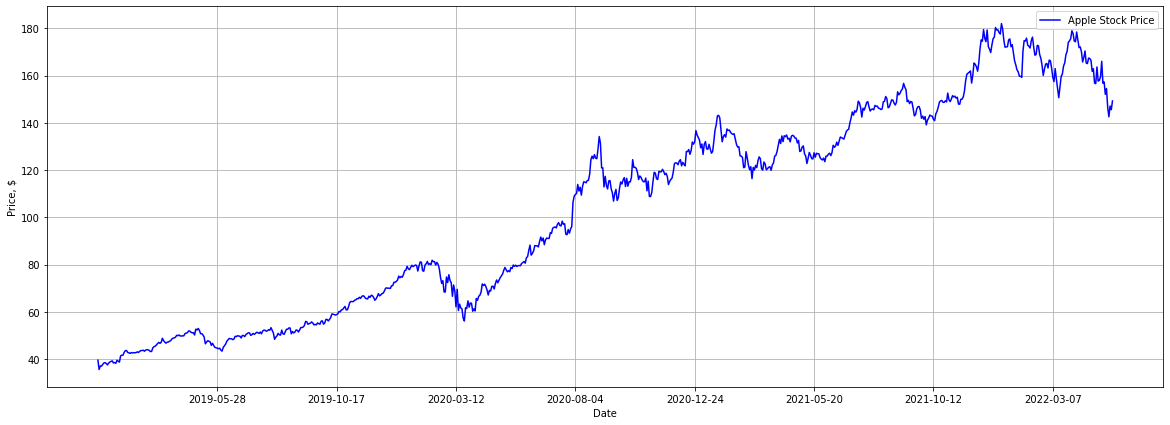

In [8]:
df['Close'] = df['Close'].astype(float)

plt.figure(figsize=(20,7))
plt.plot(df['Date'].values, df['Close'].values, label = 'Apple Stock Price', color = 'blue')
plt.xticks(np.arange(100,df.shape[0],100))
plt.xlabel('Date')
plt.ylabel('Price, $')
plt.legend()
plt.grid()
plt.show()

In [9]:
#Data Preprocessing
num_shape = 750

train = df.iloc[:num_shape, 1:2].values
test = df.iloc[num_shape:, 1:2].values

In [10]:
sc = MinMaxScaler(feature_range = (0, 1))
train_scaled = sc.fit_transform(train)

In [11]:
X_train = []

#Price on next day
y_train = []

window = 30

for i in range(window, num_shape):
    X_train_ = np.reshape(train_scaled[i-window:i, 0], (window, 1))
    X_train.append(X_train_)
    y_train.append(train_scaled[i, 0])
X_train = np.stack(X_train)
y_train = np.stack(y_train)

Создадим реккурентную нейронную сеть архитектуры LSTM с 4 блоками LSTM

In [12]:
# Initializing the Recurrent Neural Network
#Adding the first LSTM layer with a sigmoid activation function and some Dropout regularization
#Units - dimensionality of the output space


model = Sequential([LSTM(units = 24, return_sequences = True, input_shape = (X_train.shape[1], 1)),
                    Dropout(0.2),
                    LSTM(units = 24, return_sequences = True),
                    Dropout(0.2),
                    LSTM(units =24, return_sequences = True),
                    Dropout(0.2),
                    LSTM(units = 24, return_sequences = True),
                    Dropout(0.2),
                    LSTM(units = 24, return_sequences = True),
                    Dropout(0.2),
                    Dense(units = 1)
                    ])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 24)            2496      
                                                                 
 dropout (Dropout)           (None, 30, 24)            0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 24)            4704      
                                                                 
 dropout_1 (Dropout)         (None, 30, 24)            0         
                                                                 
 lstm_2 (LSTM)               (None, 30, 24)            4704      
                                                                 
 dropout_2 (Dropout)         (None, 30, 24)            0         
                                                                 
 lstm_3 (LSTM)               (None, 30, 24)            4

In [13]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs = 300, batch_size = 64);

Epoch 1/300
12/12 [==============================] - 14s 79ms/step - loss: 0.1720
Epoch 2/300
12/12 [==============================] - 1s 86ms/step - loss: 0.1118
Epoch 3/300
12/12 [==============================] - 1s 82ms/step - loss: 0.0958
Epoch 4/300
12/12 [==============================] - 1s 86ms/step - loss: 0.0882
Epoch 5/300
12/12 [==============================] - 1s 83ms/step - loss: 0.0841
Epoch 6/300
12/12 [==============================] - 1s 78ms/step - loss: 0.0817
Epoch 7/300
12/12 [==============================] - 1s 76ms/step - loss: 0.0802
Epoch 8/300
12/12 [==============================] - 1s 76ms/step - loss: 0.0789
Epoch 9/300
12/12 [==============================] - 1s 78ms/step - loss: 0.0782
Epoch 10/300
12/12 [==============================] - 1s 81ms/step - loss: 0.0772
Epoch 11/300
12/12 [==============================] - 1s 81ms/step - loss: 0.0765
Epoch 12/300
12/12 [==============================] - 1s 83ms/step - loss: 0.0759
Epoch 13/300
12/12 [====

In [14]:
#Prediction
df_volume = np.vstack((train, test))

inputs = df_volume[df_volume.shape[0] - test.shape[0] - window:]
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

num_2 = df_volume.shape[0] - num_shape + window

X_test = []

for i in range(window, num_2):
    X_test_ = np.reshape(inputs[i-window:i, 0], (window, 1))
    X_test.append(X_test_)
    
X_test = np.stack(X_test)

In [15]:
predict = model.predict(X_test)[:, 1]
predict = sc.inverse_transform(predict)
#predict.shape
#print(predict)

In [16]:
#Metrics
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

print('MAE', mean_absolute_error(test, predict))
print('MAPE', mean_absolute_percentage_error(test, predict))
print('MSE', mean_squared_error(test, predict))
print('RMSE', np.sqrt(mean_squared_error(test, predict)))

MAE 68.70746208239385
MAPE 0.4102580485543833
MSE 4792.2387561042215
RMSE 69.2259976894824


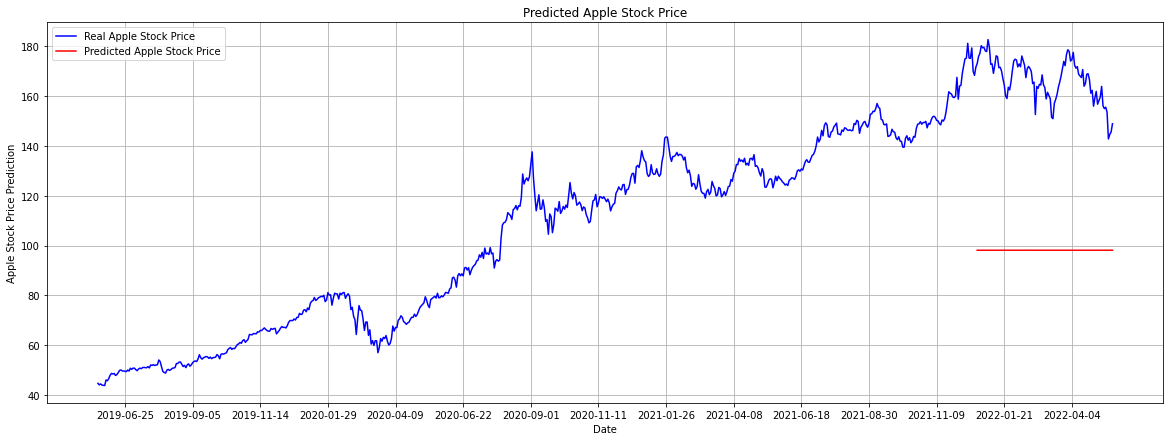

In [17]:
plt.figure(figsize=(20,7))
plt.plot(df['Date'].values[100:], df_volume[100:], color = 'blue', label = 'Real Apple Stock Price')
plt.plot(df['Date'][-predict.shape[0]:].values, predict, color = 'red', label = 'Predicted Apple Stock Price')
plt.xticks(np.arange(20,df[100:].shape[0],50))
plt.title('Predicted Apple Stock Price')
plt.xlabel('Date')
plt.ylabel('Apple Stock Price Prediction')
plt.legend()
plt.grid()
plt.show()

In [18]:
#10 days prediction
pred_ = predict[-1].copy()
prediction_full = []
window = 30
df_copy = df.iloc[:, 1:2][1:].values

for j in range(10):
    df_ = np.vstack((df_copy, pred_))
    train_ = df_[:num_shape]
    test_ = df_[num_shape:]
    
    df_volume_ = np.vstack((train_, test_))

    inputs_ = df_volume_[df_volume_.shape[0] - test_.shape[0] - window:]
    inputs_ = inputs_.reshape(-1,1)
    inputs_ = sc.transform(inputs_)

    X_test_2 = []

    for k in range(window, num_2):
        X_test_3 = np.reshape(inputs_[k-window:k, 0], (window, 1))
        X_test_2.append(X_test_3)

    X_test_ = np.stack(X_test_2)
    predict_ = model.predict(X_test_)[:, 1]
    pred_ = sc.inverse_transform(predict_)
    prediction_full.append(pred_[-1][0])
    df_copy = df_[j:]

In [19]:
prediction_full_new = np.vstack((predict, np.array(prediction_full).reshape(-1,1)))

In [20]:
df_date = df[['Date']]

for h in range(10):
    df_date_add = pd.to_datetime(df_date['Date'].iloc[-1]) + pd.DateOffset(days=1)
    df_date_add = pd.DataFrame([df_date_add.strftime("%Y-%m-%d")], columns=['Date'])
    df_date = df_date.append(df_date_add)
df_date = df_date.reset_index(drop=True)

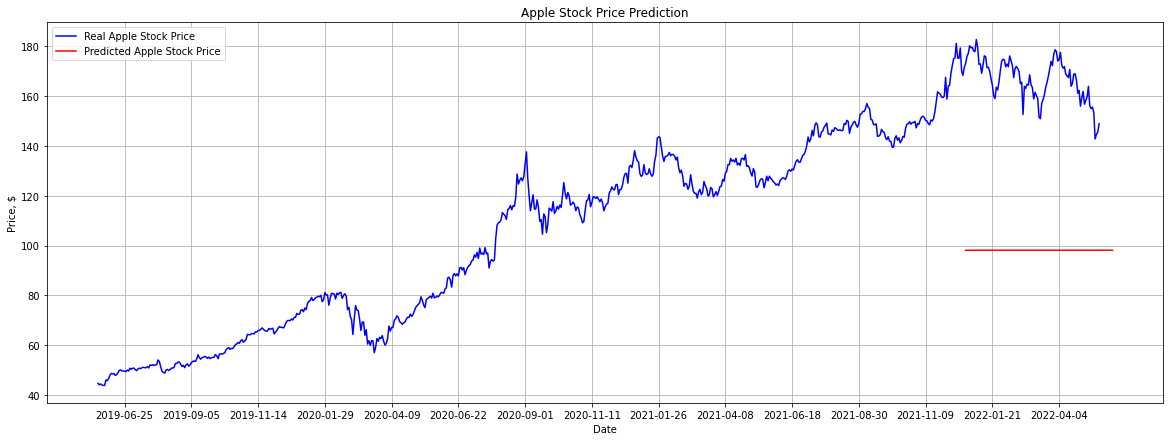

In [21]:
plt.figure(figsize=(20,7))
plt.plot(df['Date'].values[100:], df_volume[100:], color = 'blue', label = 'Real Apple Stock Price')
plt.plot(df_date['Date'][-prediction_full_new.shape[0]:].values, prediction_full_new, color = 'red', label = 'Predicted Apple Stock Price')
plt.xticks(np.arange(20,df[100:].shape[0],50))
plt.title('Apple Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price, $')
plt.legend()
plt.grid()
plt.show()

In [22]:
# The GRU architecture
modelGRU = Sequential()

modelGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
modelGRU.add(Dropout(0.2))

modelGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
modelGRU.add(Dropout(0.2))

modelGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
modelGRU.add(Dropout(0.2))

modelGRU.add(GRU(units=50))
modelGRU.add(Dropout(0.2))

modelGRU.add(Dense(units=1))
modelGRU.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 30, 50)            7950      
                                                                 
 dropout_5 (Dropout)         (None, 30, 50)            0         
                                                                 
 gru_1 (GRU)                 (None, 30, 50)            15300     
                                                                 
 dropout_6 (Dropout)         (None, 30, 50)            0         
                                                                 
 gru_2 (GRU)                 (None, 30, 50)            15300     
                                                                 
 dropout_7 (Dropout)         (None, 30, 50)            0         
                                                                 
 gru_3 (GRU)                 (None, 50)               

In [23]:
modelGRU.compile(optimizer='sgd', loss='mean_squared_error')
modelGRU.fit(X_train, y_train, epochs=300, batch_size=32)

Epoch 1/300
23/23 [==============================] - 9s 75ms/step - loss: 0.1218
Epoch 2/300
23/23 [==============================] - 2s 72ms/step - loss: 0.0696
Epoch 3/300
23/23 [==============================] - 2s 70ms/step - loss: 0.0647
Epoch 4/300
23/23 [==============================] - 2s 76ms/step - loss: 0.0592
Epoch 5/300
23/23 [==============================] - 2s 74ms/step - loss: 0.0550
Epoch 6/300
23/23 [==============================] - 2s 70ms/step - loss: 0.0513
Epoch 7/300
23/23 [==============================] - 2s 68ms/step - loss: 0.0450
Epoch 8/300
23/23 [==============================] - 2s 68ms/step - loss: 0.0398
Epoch 9/300
23/23 [==============================] - 2s 68ms/step - loss: 0.0360
Epoch 10/300
23/23 [==============================] - 2s 68ms/step - loss: 0.0309
Epoch 11/300
23/23 [==============================] - 2s 69ms/step - loss: 0.0264
Epoch 12/300
23/23 [==============================] - 2s 67ms/step - loss: 0.0220
Epoch 13/300
23/23 [=====

In [24]:
predict = modelGRU.predict(X_test)
predict = sc.inverse_transform(predict)

In [25]:
#Metrics
print('MAE', mean_absolute_error(test, predict))
print('MAPE', mean_absolute_percentage_error(test, predict))
print('MSE', mean_squared_error(test, predict))
print('RMSE', np.sqrt(mean_squared_error(test, predict)))

MAE 5.230831660929767
MAPE 0.03144986676265184
MSE 43.59441160987878
RMSE 6.60260642548674


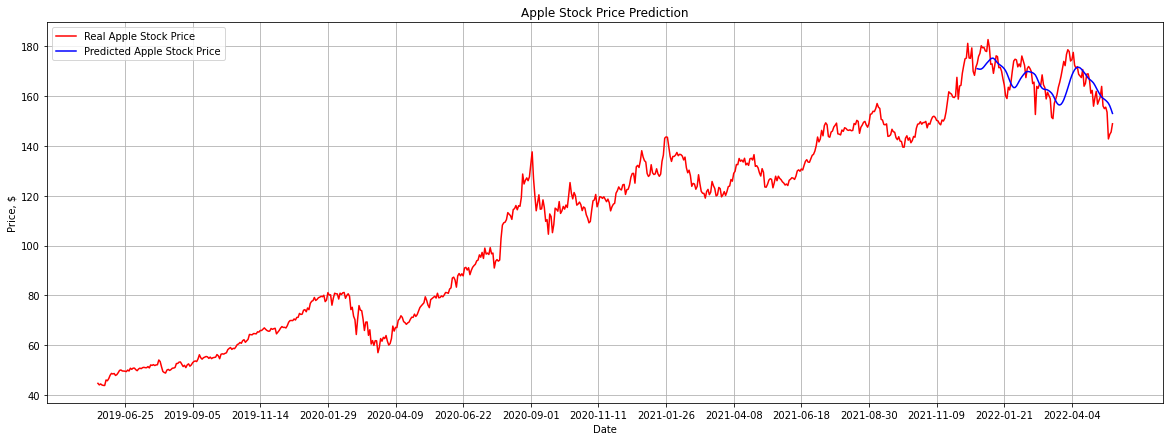

In [26]:
plt.figure(figsize=(20,7))
plt.plot(df['Date'].values[100:], df_volume[100:], color = 'red', label = 'Real Apple Stock Price')
plt.plot(df['Date'][-predict.shape[0]:].values, predict, color = 'blue', label = 'Predicted Apple Stock Price')
plt.xticks(np.arange(20,df[100:].shape[0],50))
plt.title('Apple Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price, $')
plt.legend()
plt.grid()
plt.show()

In [27]:
#10 days prediction
pred_ = predict[-1].copy()
prediction_full = []
window = 30
df_copy = df.iloc[:, 1:2][1:].values

for j in range(10):
    df_ = np.vstack((df_copy, pred_))
    train_ = df_[:num_shape]
    test_ = df_[num_shape:]
    
    df_volume_ = np.vstack((train_, test_))

    inputs_ = df_volume_[df_volume_.shape[0] - test_.shape[0] - window:]
    inputs_ = inputs_.reshape(-1,1)
    inputs_ = sc.transform(inputs_)

    X_test_2 = []

    for k in range(window, num_2):
        X_test_3 = np.reshape(inputs_[k-window:k, 0], (window, 1))
        X_test_2.append(X_test_3)

    X_test_ = np.stack(X_test_2)
    predict_ = modelGRU.predict(X_test_)
    pred_ = sc.inverse_transform(predict_)
    prediction_full.append(pred_[-1][0])
    df_copy = df_[j:]

In [28]:
prediction_full_new = np.vstack((predict, np.array(prediction_full).reshape(-1,1)))

df_date = df[['Date']]

for h in range(4):
    kk = pd.to_datetime(df_date['Date'].iloc[-1]) + pd.DateOffset(days=1)
    kk = pd.DataFrame([kk.strftime("%Y-%m-%d")], columns=['Date'])
    df_date = df_date.append(kk)
df_date = df_date.reset_index(drop=True)

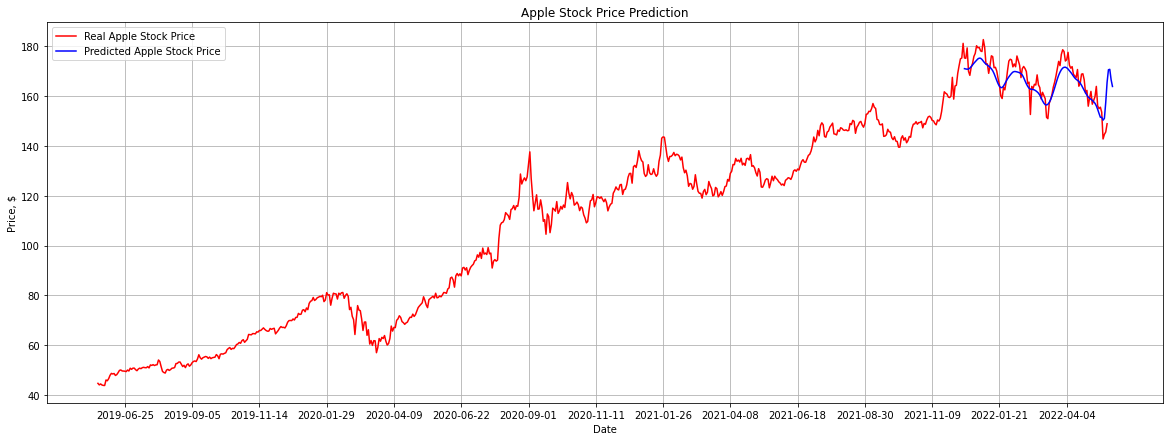

In [29]:
plt.figure(figsize=(20,7))
plt.plot(df['Date'].values[100:], df_volume[100:], color = 'red', label = 'Real Apple Stock Price')
plt.plot(df_date['Date'][-prediction_full_new.shape[0]:].values, prediction_full_new, color = 'blue', label = 'Predicted Apple Stock Price')
plt.xticks(np.arange(20,df_date[100:].shape[0],50))
plt.title('Apple Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price, $')
plt.legend()
plt.grid()
plt.show()

Подберем параметры лучше

In [29]:
# The GRU architecture
modelGRU = Sequential()

modelGRU.add(GRU(units=25, return_sequences=True, input_shape=(X_train.shape[1],1)))
modelGRU.add(Dropout(0.2))

modelGRU.add(GRU(units=25, return_sequences=True, input_shape=(X_train.shape[1],1)))
modelGRU.add(Dropout(0.2))

modelGRU.add(GRU(units=25, return_sequences=True, input_shape=(X_train.shape[1],1)))
modelGRU.add(Dropout(0.2))

modelGRU.add(GRU(units=25))
modelGRU.add(Dropout(0.2))

modelGRU.add(Dense(units=3))
modelGRU.summary()

In [29]:
modelGRU.compile(optimizer='sgd', loss='mean_squared_error')
modelGRU.fit(X_train, y_train, epochs=500, batch_size=32)

In [30]:
predict = modelGRU.predict(X_test)
predict = sc.inverse_transform(predict)

In [31]:
#Metrics
print('MAE', mean_absolute_error(test, predict))
print('MAPE', mean_absolute_percentage_error(test, predict))
print('MSE', mean_squared_error(test, predict))
print('RMSE', np.sqrt(mean_squared_error(test, predict)))

MAE 5.230831660929767
MAPE 0.03144986676265184
MSE 43.59441160987878
RMSE 6.60260642548674


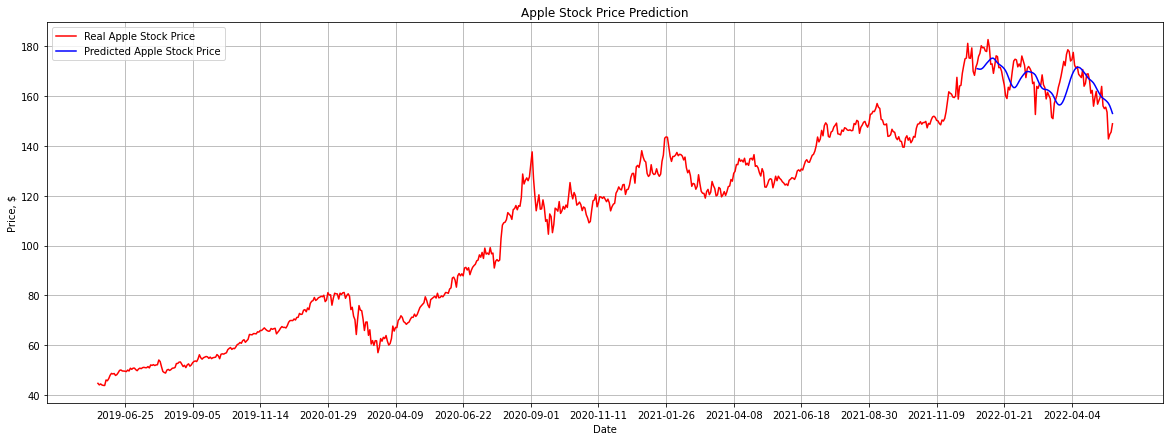

In [32]:
plt.figure(figsize=(20,7))
plt.plot(df['Date'].values[100:], df_volume[100:], color = 'red', label = 'Real Apple Stock Price')
plt.plot(df['Date'][-predict.shape[0]:].values, predict, color = 'blue', label = 'Predicted Apple Stock Price')
plt.xticks(np.arange(20,df[100:].shape[0],50))
plt.title('Apple Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price, $')
plt.legend()
plt.grid()
plt.show()

In [33]:
#10 days prediction
pred_ = predict[-1].copy()
prediction_full = []
window = 30
df_copy = df.iloc[:, 1:2][1:].values

for j in range(10):
    df_ = np.vstack((df_copy, pred_))
    train_ = df_[:num_shape]
    test_ = df_[num_shape:]
    
    df_volume_ = np.vstack((train_, test_))

    inputs_ = df_volume_[df_volume_.shape[0] - test_.shape[0] - window:]
    inputs_ = inputs_.reshape(-1,1)
    inputs_ = sc.transform(inputs_)

    X_test_2 = []

    for k in range(window, num_2):
        X_test_3 = np.reshape(inputs_[k-window:k, 0], (window, 1))
        X_test_2.append(X_test_3)

    X_test_ = np.stack(X_test_2)
    predict_ = modelGRU.predict(X_test_)
    pred_ = sc.inverse_transform(predict_)
    prediction_full.append(pred_[-1][0])
    df_copy = df_[j:]

In [34]:
prediction_full_new = np.vstack((predict, np.array(prediction_full).reshape(-1,1)))

df_date = df[['Date']]

for h in range(4):
    kk = pd.to_datetime(df_date['Date'].iloc[-1]) + pd.DateOffset(days=1)
    kk = pd.DataFrame([kk.strftime("%Y-%m-%d")], columns=['Date'])
    df_date = df_date.append(kk)
df_date = df_date.reset_index(drop=True)

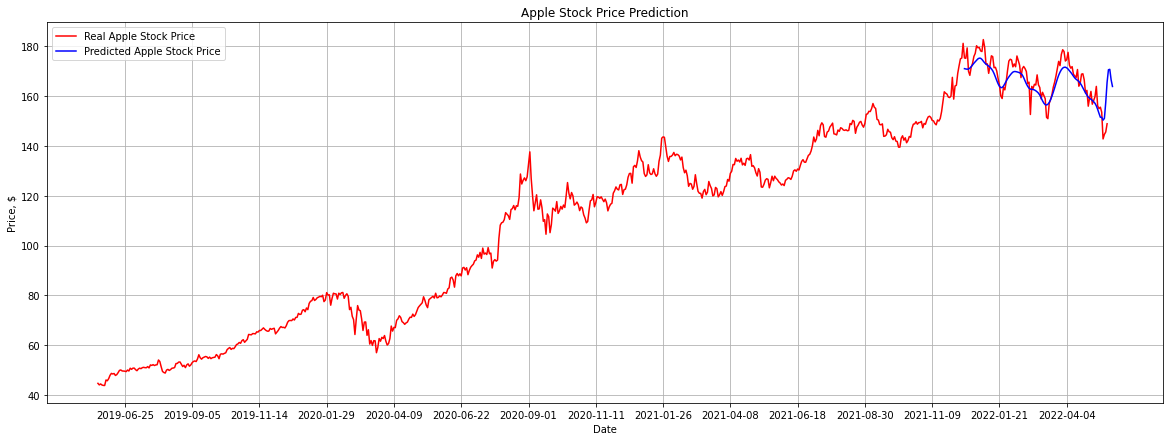

In [35]:
plt.figure(figsize=(20,7))
plt.plot(df['Date'].values[100:], df_volume[100:], color = 'red', label = 'Real Apple Stock Price')
plt.plot(df_date['Date'][-prediction_full_new.shape[0]:].values, prediction_full_new, color = 'blue', label = 'Predicted Apple Stock Price')
plt.xticks(np.arange(20,df_date[100:].shape[0],50))
plt.title('Apple Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price, $')
plt.legend()
plt.grid()
plt.show()